<a href="https://colab.research.google.com/github/FleaBusyBeeBergs/dtsa5506-pipeline/blob/main/statcan_etl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install scikit-learn-intelex -q
!pip install statsmodels==0.14.0 -q
!pip install tslearn -q

In [82]:
# file handling & general
import numpy as np
import pandas as pd
import os
from google.colab import files
import xml.etree.ElementTree as ET
import warnings
warnings.filterwarnings('ignore',
                        message = '''.*'force_all_finite' was renamed to 'ensure_all_finite'.*''')

# http requests
import requests

# vis
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

# eda
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import scipy.stats as stats

# pca
from sklearn.decomposition import PCA
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import DBSCAN

# preprocessing & ml
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

#
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# clustering
from tslearn.clustering import TimeSeriesKMeans
from tslearn import metrics

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## ETL pipeline

Stats can has tools to make http requests for date from their cube. [1]

In [33]:
# base URL for data extraction
base_url = 'https://www150.statcan.gc.ca/t1/wds/sdmx/statcan/rest/vector/'

I was able to make a request for a single vector, but needed help with transforming the XML output that was extracted. I spent a lot of time trying to write a loop to extract and parse multiple vectors, and ended up using a code generator [2] for the following StatCanETL class:

In [34]:
# namespace mappings for XML parsing
namespaces = {
    "message": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message',
    "generic": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic',
    "common": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/common',
}


In [35]:
class StatCanETL:
    def __init__(self, table_df):
        '''initialize with df of metadata table'''
        self.table_df = table_df
        self.data_objects = {}

    def extract(self, vector, start_period, end_period):
        '''extract data from the StatCan API for a given vector, start, and end dates'''
        url = f'{base_url}{vector}?startPeriod={start_period}&endPeriod={end_period}&detail=full'
        response = requests.get(url)

        if response.status_code == 200:
            return response.content
        else:
            raise ValueError(f'Failed to fetch data for vector {vector}. HTTP Status: {response.status_code}')

    def transform(self, xml_content, frequency):
        '''transform the XML response into a structured DataFrame.'''
        # parse XML content
        root = ET.fromstring(xml_content)

        # locate the series element
        series = root.find('.//generic:Series', namespaces)
        if series is None:
            raise ValueError('No Series element found in the XML response')

        # extract obs
        observations = series.findall('.//generic:Obs', namespaces)
        data = []
        for obs in observations:
            obs_dim = obs.find('.//generic:ObsDimension', namespaces)
            obs_val = obs.find('.//generic:ObsValue', namespaces)
            date = obs_dim.attrib['value']

            # convert date format if quarterly or yearly
            if frequency == 'quarterly':
                date = self.convert_quarter_to_date(date)
            elif frequency == 'yearly':
                date = date[:4] + '-01'

            data.append({
                'Date': date,
                'Value': float(obs_val.attrib['value']),
            })

        # convert to df
        df = pd.DataFrame(data)
        return df

    @staticmethod
    def convert_quarter_to_date(quarter_str):
        '''convert quarterly date string (YYYY-Qx) to a standard date format (YYYY-MM)'''
        try:
            year, quarter = quarter_str.split('-Q')
            quarter_start_month = {
                '1': '01',
                '2': '04',
                '3': '07',
                '4': '10',
            }.get(quarter)
            if quarter_start_month:
                return f'{year}-{quarter_start_month}'
            else:
                raise ValueError(f'Invalid quarter format: {quarter_str}')
        except Exception as e:
            raise ValueError(f'Error converting quarter string {quarter_str}: {e}')

    def load(self, df, name):
        '''load df into object named name_df.'''
        variable_name = f'{name}_df'
        globals()[variable_name] = df
        self.data_objects[variable_name] = df
        print(f'Data for {name} saved to object {variable_name}')

    def run(self):
        '''Run the full ETL pipeline for all variables'''
        for _, row in self.table_df.iterrows():
            print(f'Processing {row["name"]}...')
            try:
                # extract
                xml_content = self.extract(row['vector'], row['start'], row['end'])

                # transform
                df = self.transform(xml_content, row['frequency'])

                # load
                self.load(df, row['name'])
            except Exception as e:
                print(f'Error processing {row["name"]}: {e}')

In [36]:
# define table metadata
tables = {
    'name': ['wage', 'rmpi', 'tax', 'productivity', 'cpi'],
    'tableid': [14100223, 18100268, 11100058, 36100206, 18100004],
    'vector': ['v79311153', 'v1230998135', 'v122807833', 'v1409153', 'v41690973'],
    'description': ['', '', '', '', ''],
    'frequency': ['monthly', 'monthly', 'yearly', 'quarterly', 'monthly'],
    'start': ['2001-01', '2001-01', '2001-01', '2001-Q1', '2001-01'],
    'end': ['2024-12', '2024-12', '2024-12', '2024-Q4', '2024-12']
}

# make df
table_df = pd.DataFrame(tables)

In [37]:
# run ETL pipe
pipeline = StatCanETL(table_df)
pipeline.run()

Processing wage...
Data for wage saved to object wage_df
Processing rmpi...
Data for rmpi saved to object rmpi_df
Processing tax...
Data for tax saved to object tax_df
Processing productivity...
Data for productivity saved to object productivity_df
Processing cpi...
Data for cpi saved to object cpi_df


## EDA and cleaning

**check to see if the data loaded correctly:**

In [38]:
for key, value in pipeline.data_objects.items():
    print(key)
    print(value.head(3))

wage_df
      Date   Value
0  2001-01  657.14
1  2001-02  653.59
2  2001-03  655.14
rmpi_df
      Date  Value
0  2001-01   65.2
1  2001-02   65.8
2  2001-03   65.5
tax_df
      Date  Value
0  2001-01   14.0
1  2002-01   13.8
2  2003-01   13.8
productivity_df
      Date   Value
0  2001-01  85.173
1  2001-04  86.150
2  2001-07  86.665
cpi_df
      Date  Value
0  2001-01   96.3
1  2001-02   96.8
2  2001-03   97.1


Rename columns

In [39]:
wage_df.rename(columns = {'Value': 'wage'}, inplace = True)
rmpi_df.rename(columns = {'Value': 'rmpi'}, inplace = True)
tax_df.rename(columns = {'Value': 'tax'}, inplace = True)
productivity_df.rename(columns = {'Value': 'productivity'}, inplace = True)
cpi_df.rename(columns={'Value': 'cpi'}, inplace = True)

Merge tables

In [40]:
data = wage_df.merge(rmpi_df, on = 'Date', how = 'outer') \
                .merge(tax_df, on = 'Date', how = 'outer') \
                .merge(productivity_df, on = 'Date', how = 'outer') \
                .merge(cpi_df, on = 'Date', how = 'outer')

Because productivity has quarterly observations and tax has yearly observations, the NaN values need to be dealt with. I used forward fill for this.

In [41]:
data = data.ffill()
# if data is missing from the end of a series, then forward fill also fills in those values with the previous entry. just something to keep in mind.

In [42]:
data

,Date,wage,rmpi,tax,productivity,cpi
0,2001-01,657.14,65.2,14.0,85.173,96.3
1,2001-02,653.59,65.8,14.0,85.173,96.8
2,2001-03,655.14,65.5,14.0,85.173,97.1
3,2001-04,652.44,65.2,14.0,86.150,97.8
4,2001-05,652.28,65.3,14.0,86.150,98.6
...,...,...,...,...,...,...
283,2024-08,1274.25,139.3,13.0,101.372,161.8
284,2024-09,1277.70,134.8,13.0,101.372,161.1
285,2024-10,1284.24,140.3,13.0,101.372,161.8
286,2024-11,1285.91,140.2,13.0,101.372,161.8


In [43]:
# descriptive stats
data.describe()

,wage,rmpi,tax,productivity,cpi
count,288.000000,288.000000,288.000000,288.000000,288.000000
mean,911.631250,99.128125,12.962500,95.849490,123.738542
std,170.097978,24.307042,0.512271,6.138403,17.143681
min,652.280000,55.300000,12.200000,85.173000,96.300000
25%,772.157500,84.075000,12.600000,91.273250,109.775000
50%,903.520000,97.050000,12.900000,94.349000,122.200000
75%,1009.597500,112.725000,13.125000,100.465500,134.225000
max,1285.910000,166.600000,14.000000,119.771000,162.100000


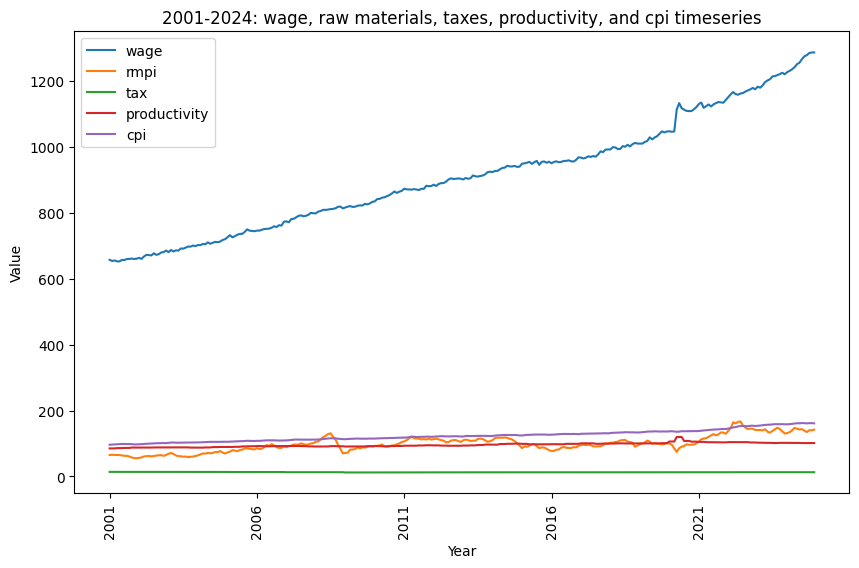

In [44]:
# plot raw data
plt.figure(figsize=(10, 6))

for var in data.columns[1:]:
    plt.plot(data['Date'], data[var], label = var)

    plt.xlabel('Year')
    x_tick_labels = [pd.to_datetime(d).year for d in data['Date'][::60]]
    plt.xticks(data['Date'][::60], x_tick_labels, rotation=90)

    plt.ylabel('Value')

    plt.title('2001-2024: wage, raw materials, taxes, productivity, and cpi timeseries')
    plt.legend()


Here I am comparing different variables of very different magnitudes with each other. Consider comparing a grape against an apple and 10Kg watermelon. The data needs to be scaled. Sklearn's standard scaler is good for time series if it is stationary, min-max scaler preserves the shape of time series data while scaling features. I'll conduct a test for stationarity to decide which scaler I should use.

In [45]:
# categorize variables
numerical_vars = ['wage', 'rmpi', 'tax', 'productivity', 'cpi']

### Augmented Dickey-Fuller (ADF) test for stationary time series

In [46]:
# adf test
adf_results_list = []
for feature in numerical_vars:
    adf_results = adfuller(data[feature])
    adf_results_list.append([feature,
                             adf_results[0],
                             adf_results[1],
                             adf_results[4]['5%'],
                             adf_results[4]['10%']])

adf_results_df = pd.DataFrame(adf_results_list, columns=['variable',
                                                         'ADF Statistic',
                                                         'p-value',
                                                         '5%',
                                                         '10%'])
adf_results_df

,variable,ADF Statistic,p-value,5%,10%
0,wage,2.425141,0.999022,-2.872031,-2.572360
1,rmpi,-1.854706,0.353659,-2.871699,-2.572183
2,tax,-2.045313,0.267065,-2.871664,-2.572164
3,productivity,-1.549093,0.509101,-2.871881,-2.572280
4,cpi,0.725756,0.990338,-2.872108,-2.572401


With the ADF test, the null hypothesis is that the time series has a root unit - this means it is non-stationary. The alternative hypothesis is that the time series is stationary. Given the very large p-values above, we fail to reject the null hypothesis: the time series for all 5 variables have a root unit.


I'll try some transformations to see if I can make them stationary, as some time series models like ARIMA assume a stationary time series.

In [47]:
scaler = MinMaxScaler()
data[numerical_vars] = scaler.fit_transform(data[numerical_vars])
data.describe()

,wage,rmpi,tax,productivity,cpi
count,288.000000,288.000000,288.000000,288.000000,288.000000
mean,0.409310,0.393784,0.423611,0.308587,0.416999
std,0.268450,0.218392,0.284595,0.177421,0.260542
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.189192,0.258535,0.222222,0.176318,0.204787
50%,0.396509,0.375112,0.388889,0.265218,0.393617
75%,0.563921,0.515948,0.513889,0.442005,0.576368
max,1.000000,1.000000,1.000000,1.000000,1.000000


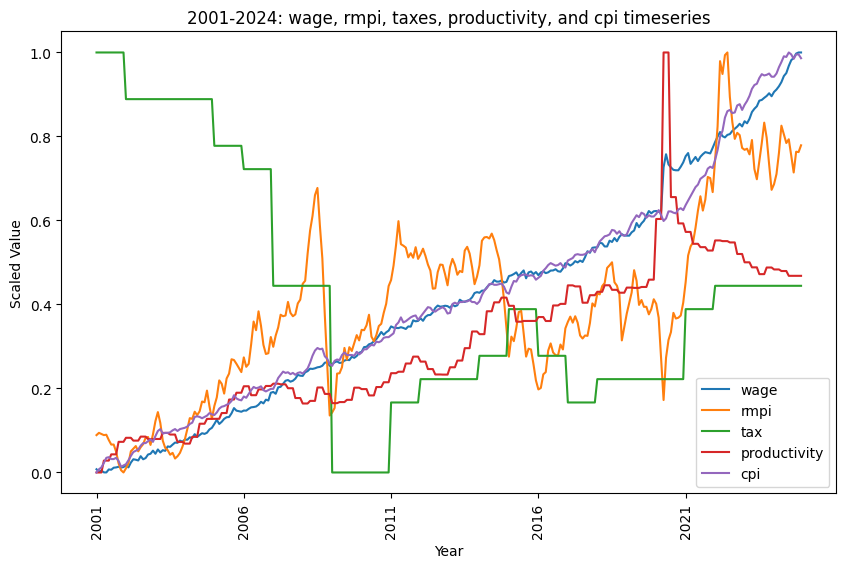

In [48]:
# plot scaled data
plt.figure(figsize=(10, 6))

for var in data.columns[1:]:
    plt.plot(data['Date'], data[var], label = var)

plt.xlabel('Year')
x_tick_labels = [pd.to_datetime(d).year for d in data['Date'][::60]]
plt.xticks(data['Date'][::60], x_tick_labels, rotation=90)

plt.ylabel('Scaled Value')

plt.title('2001-2024: wage, rmpi, taxes, productivity, and cpi timeseries')
plt.legend()

Scaling the data has made it easier to compare the changes to the respective variables with each other, but the overall patterns have been preserved. More transforming is required to achieve stationary data. Differencing will compute the differences between consecutive obervations, so that seasonality and trends are reduced and the variance is stabilized.

In [49]:
# differencing
for var in numerical_vars:
    data[var + '_diff'] = data[var].diff()

data.dropna(inplace = True)

data.head(3)

,Date,wage,rmpi,tax,productivity,cpi,wage_diff,rmpi_diff,tax_diff,productivity_diff,cpi_diff
1,2001-02,0.002067,0.094340,1.0,0.000000,0.007599,-0.005603,0.005391,0.0,0.000000,0.007599
2,2001-03,0.004514,0.091644,1.0,0.000000,0.012158,0.002446,-0.002695,0.0,0.000000,0.004559
3,2001-04,0.000253,0.088949,1.0,0.028239,0.022796,-0.004261,-0.002695,0.0,0.028239,0.010638


In [50]:
# another adf test
adf_results_list2 = []
for feature in numerical_vars:
    adf_results2 = adfuller(data[feature + '_diff'])
    adf_results_list2.append([feature,
                              adf_results2[0],
                              adf_results2[1],
                              adf_results2[4]['5%'],
                              adf_results2[4]['10%']])

adf_results_df2 = pd.DataFrame(adf_results_list2,
                               columns = ['variable',
                                          'ADF Statistic',
                                          'p-value',
                                          '5%',
                                          '10%'])
adf_results_df2

,variable,ADF Statistic,p-value,5%,10%
0,wage,-4.572952,1.448384e-04,-2.872031,-2.572360
1,rmpi,-9.002268,6.449738e-15,-2.871808,-2.572241
2,tax,-16.897117,1.034442e-29,-2.871699,-2.572183
3,productivity,-8.857645,1.512643e-14,-2.871881,-2.572280
4,cpi,-2.956486,3.916281e-02,-2.872108,-2.572401


Given the very small p-values from the second ADF test, we now have evidence of stationary time series. Next up are some more visualizations for each decade of the timeseries, as well as visualizing some major economic events: the recession around 2008, and the more recent recession from the COVID-19 pandemic.

In [51]:
data_2001_2010 = data[data['Date'].between('2001-01-01', '2010-12-01')]
data_2011_2020 = data[data['Date'].between('2011-01-01', '2020-12-01')]
data_2015_2024 = data[data['Date'].between('2015-01-01', '2024-12-01')]

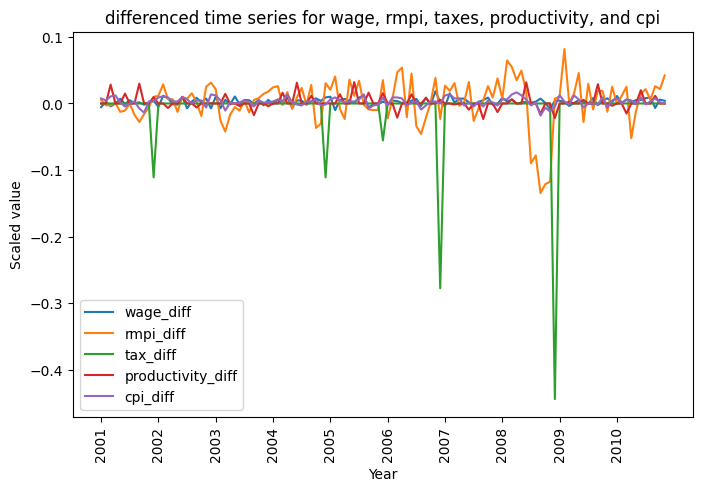

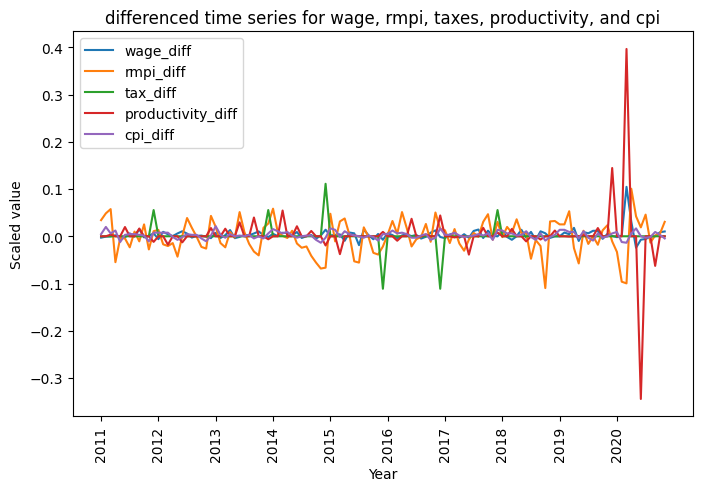

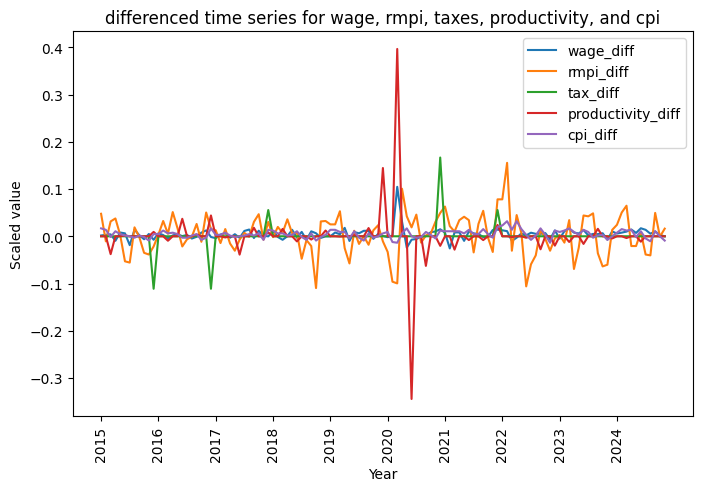

In [52]:
decades = [data_2001_2010, data_2011_2020, data_2015_2024]

for decade in decades:
    plt.figure(figsize = (8, 5))

    # only diff cols
    diff_cols = [col for col in decade.columns if col.endswith('_diff')]

    for var in diff_cols:
        plt.plot(decade['Date'], decade[var], label = var)

        plt.xlabel('Year')
        x_tick_labels = [pd.to_datetime(d).year for d in decade['Date'][::12]]
        plt.xticks(decade['Date'][::12], x_tick_labels, rotation = 90)

        plt.ylabel('Scaled value')

        plt.title('differenced time series for wage, rmpi, taxes, productivity, and cpi')
        plt.legend()

In [83]:
# recession events
recession_1 = data[data['Date'].between('2007-01-01', '2010-12-01')] # I remember that... fun times!
recession_2 = data[data['Date'].between('2019-01-01', '2023-12-01')] # also fun times!
stable = data[data['Date'].between('2009-07-01', '2018-06-30')]

# ref: https://www.thecanadianencyclopedia.ca/en/article/recession

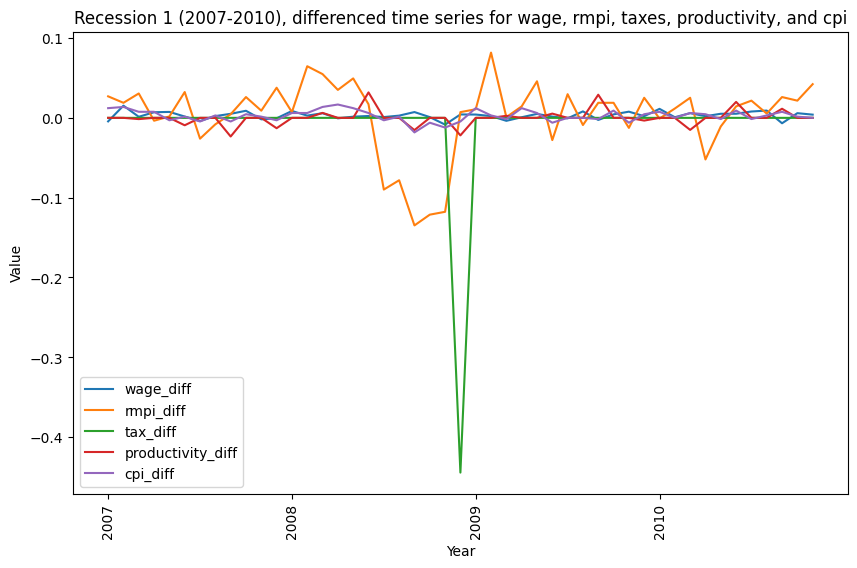

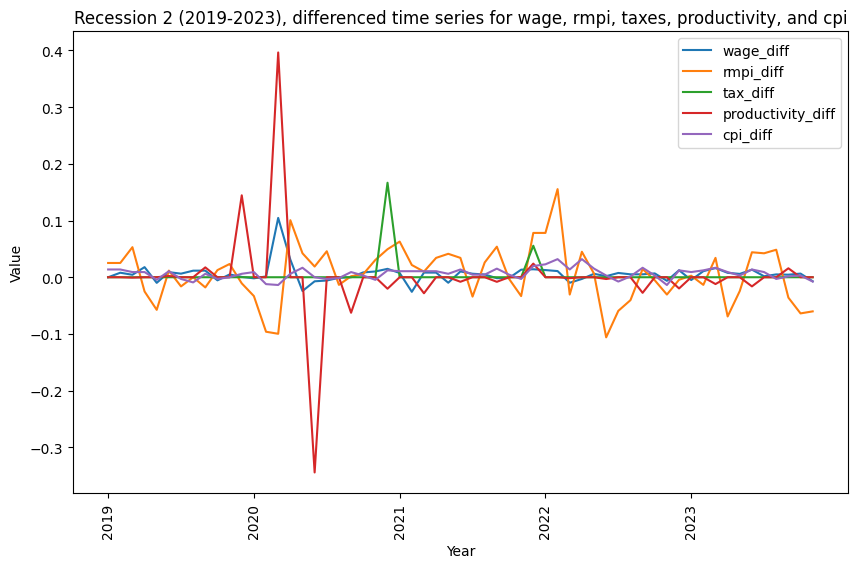

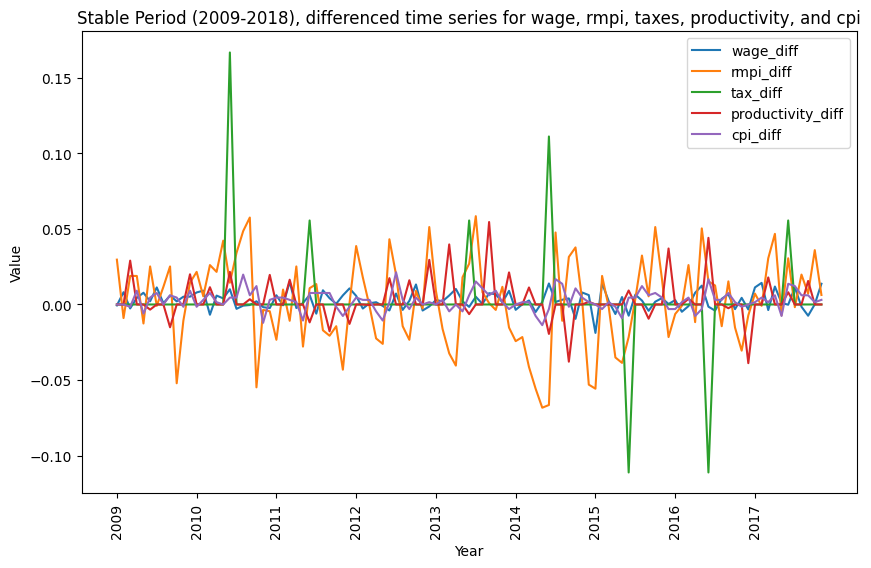

In [86]:
events = {'Recession 1 (2007-2010)': recession_1,
          'Recession 2 (2019-2023)': recession_2,
          'Stable Period (2009-2018)': stable}

for event_name, event_df in events.items():
    plt.figure(figsize = (10, 6))

    # only diff cols
    diff_cols = [col for col in event.columns if col.endswith('_diff')]

    for var in diff_cols:
        plt.plot(event_df['Date'],
                 event_df[var],
                 label = var)
        plt.xlabel('Year')
        x_tick_labels = [pd.to_datetime(d).year for d in event_df['Date'][::12]]
        plt.xticks(event_df['Date'][::12],
                   x_tick_labels,
                   rotation = 90)
        plt.ylabel('Value')
        plt.title(f'{event_name}, differenced time series for wage, rmpi, taxes, productivity, and cpi')
        plt.legend()
    plt.show()

### Autocorrelation and partial autocorrelation

Next, I'll perform autocorrelation analysis to understand the correlation of each time series with its own lagged values. This will help to identify seasonality, perhaps the cyclical nature of the economy, other trends, and the persistence of values over time.

In [55]:
trf_vars = [col for col in data.columns if col.endswith('_diff')]

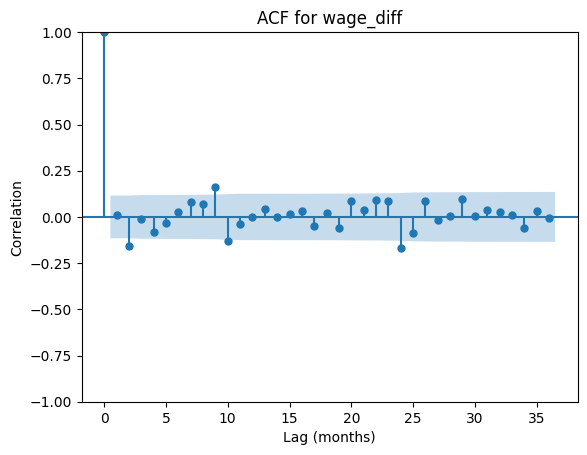

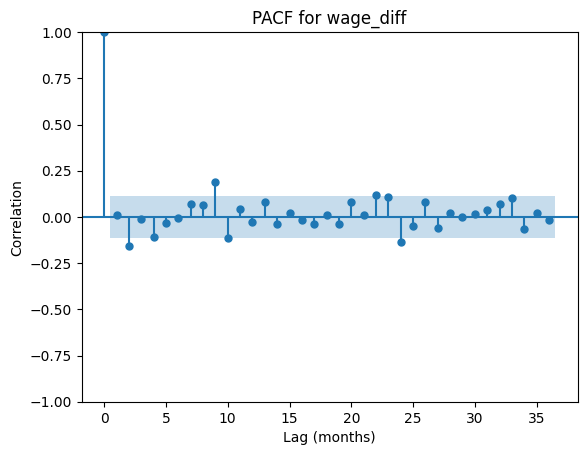

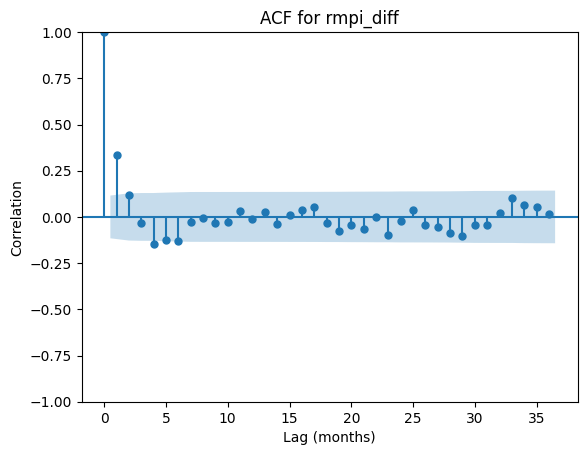

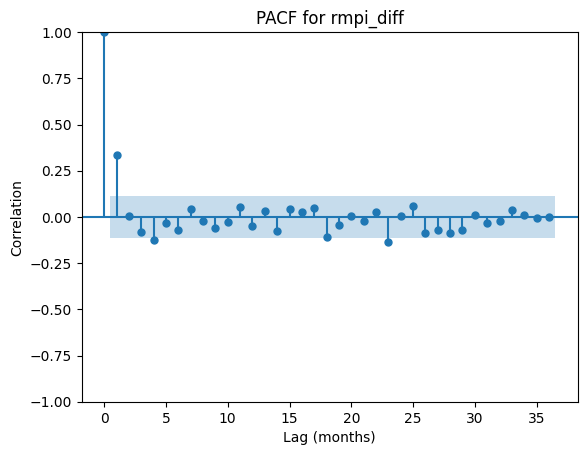

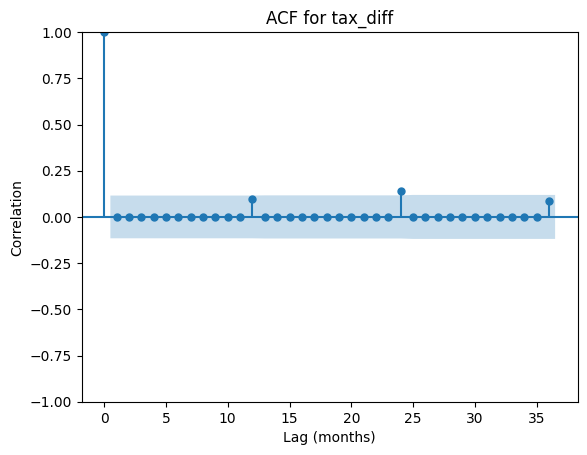

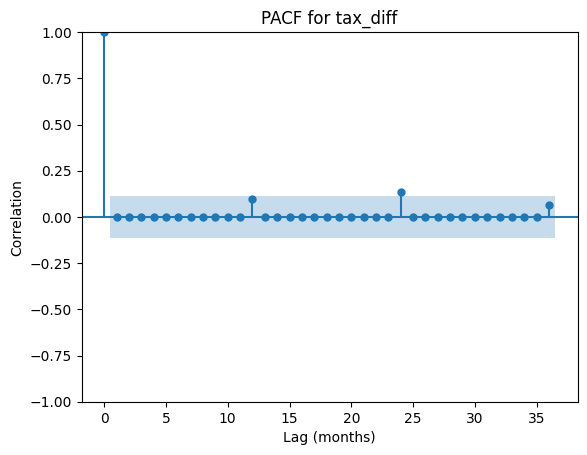

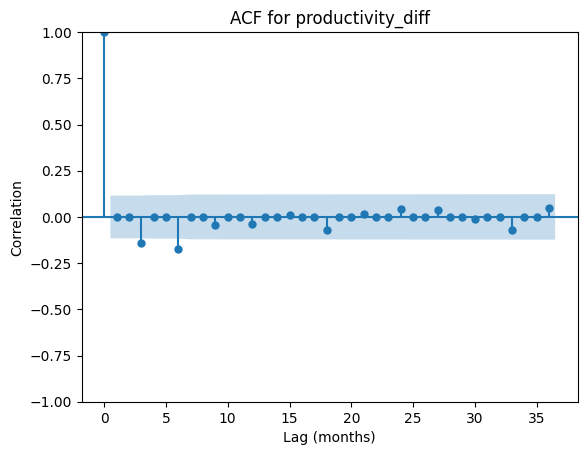

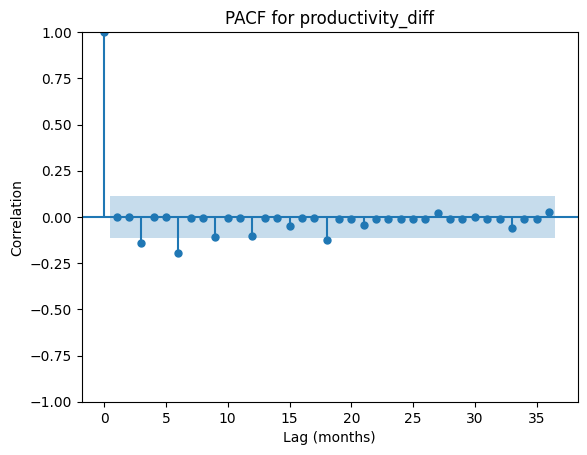

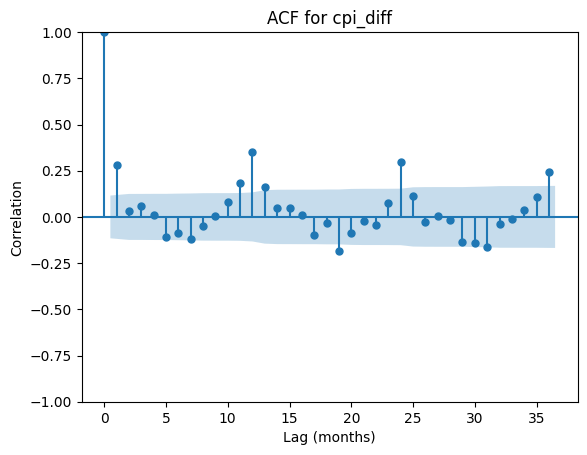

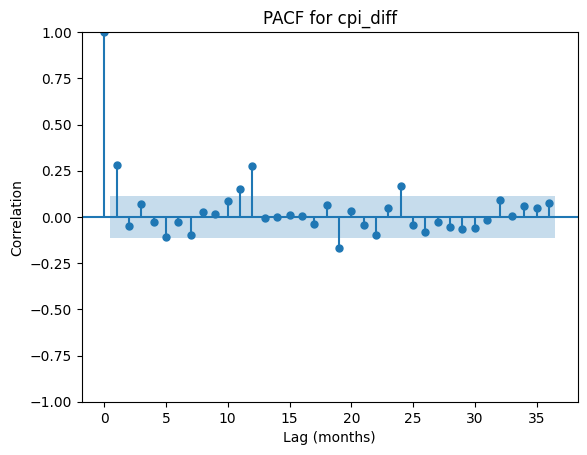

In [56]:
# acf & pcf
for var in trf_vars:
  plot_acf(data[var], lags = 36)
  plt.title(f'ACF for {var}')
  plt.xlabel('Lag (months)')
  plt.ylabel('Correlation')
  plt.show()

  plot_pacf(data[var], lags = 36)
  plt.title(f'PACF for {var}')
  plt.xlabel('Lag (months)')
  plt.ylabel('Correlation')
  plt.show()


ACF plots: visualize how each current data point is related to it's past values. The x-axis represents the time difference in months between each point.The very first point (lag = 0) is compared to itself and always has a correlation of 1.0, the second point (lag = 1) compares the current point to the value from 1 month ago, and so on. The shaded blue band shows the confidence interval - if a point falls outside the band, it is considered statistically significant.

The PCF plot is similar to the ACF plot, except is focuses on the direct relationship between the current and previous points, removing the influence of the intermediate lags.




*   Wage series: we see statistically significant correlations at lag = [2, 9, maybe 10, 24] points. This intrigues me, but regretfully I don't have the time to look into the meaning of this pattern.
*   RMPI series: we see statistically significant correlations at lag = [1, 4] points. Again I find this interesting but looking further into will have to wait.
*   Tax series: we can see the yearly pattern emerge in both the ACF and PCF plots with a 'blip' in the line every 12 months. While the points don't all lie outside the confidence interval, it is common knowledge that the CRA sets new tax rates for each calendar year.
*   Productivity series: we can see the quarterly pattern in both the ACF and PCF plots with a blip every 3 months, as that is how often the productivity data is updated in the vector series by Statistics Canada. Both plots indicate that each quarterly point is correlated with the last 2 quarterly points.
*   CPI series: the seasonal fluctuation is apparent in the ACF plot - there are statistically significant high correlation points at the lag = [12, 24, 36] points, and (almost) statistically significant low correlation points at the lag = [ 7, 19, 31] points.  



### Cross-correlation

The cross-correlation measures the similarity between the features and the target as a function of lag on one, relative to the other. It can indicate how much one time series leads or lags another. Where there are negative cross-correlations, the two series are moving in opposite directions; where there are positive correlations, the two series are moving in the same direction.

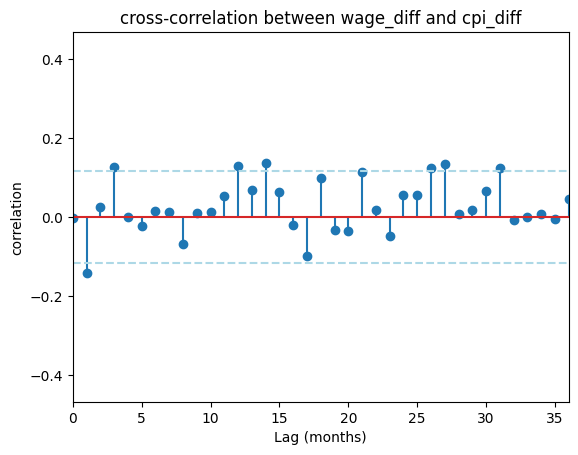

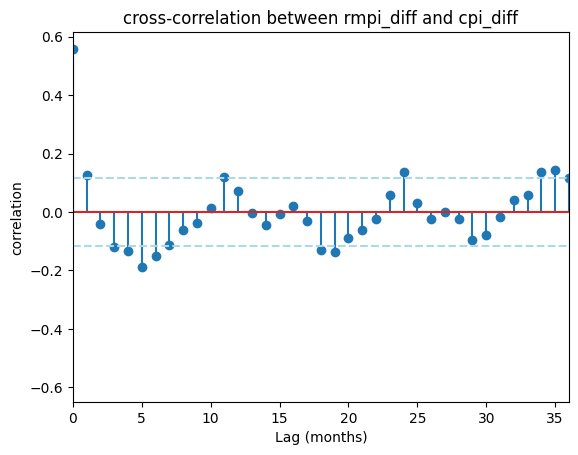

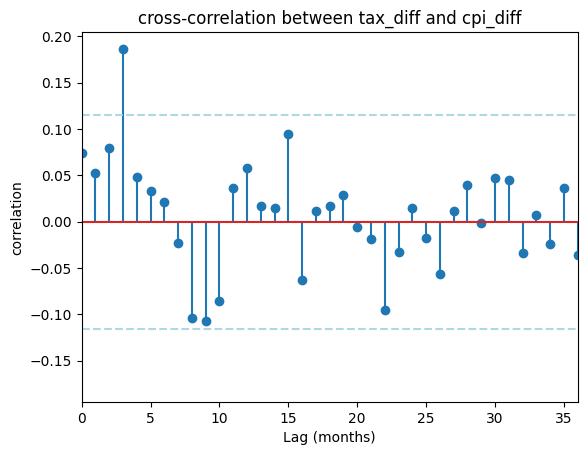

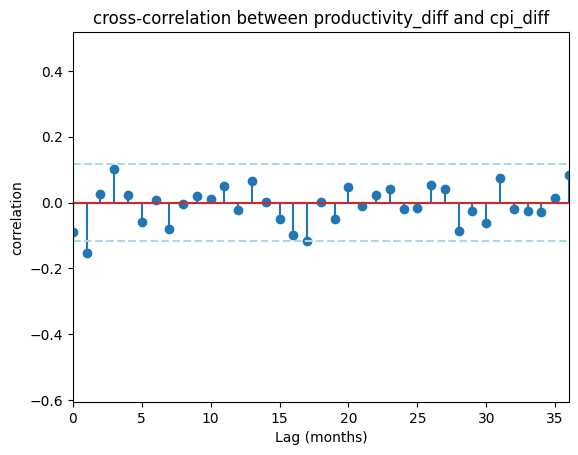

In [58]:
# ccf
x = ['wage_diff', 'rmpi_diff', 'tax_diff', 'productivity_diff']
y = 'cpi_diff'

for var in x:
  ccf_results = sm.tsa.stattools.ccf(data[var], data[y])

  # conf int
  n = len(data[var])
  conf_level = 0.95
  lower, upper = stats.norm.interval(conf_level,
                                     loc = 0,
                                     scale = 1/np.sqrt(n))

  plt.stem(ccf_results)
  plt.title(f'cross-correlation between {var} and {y}')

  plt.xlabel('Lag (months)')

  plt.ylabel('correlation')
  plt.xlim(0, 36)

  plt.axhline(y = lower,
              color = 'lightblue',
              linestyle = '--',
              label = f'{conf_level*100:.0f}% Confidence Interval')
  plt.axhline(y = upper,
              color = 'lightblue',
              linestyle = '--')
  plt.show()




*   rmpi_diff and cpi_diff: there again seems to be a seasonal fluctuation between rmpi and cpi, with statistically significant correlations at _approximately_ 12 month intervals. This may indicate that it takes approximately one year for raw materials pricing to affect the cpi. Further investigation would be needed to substantiate this.
*   productivity_diff and cpi_diff: there appears to be a significant negative correlation at lag = 1.
* wage_diff and cpi_dff:lag = [1, 3, 12, 14]
* tax_diff and cpi_diff: lag = 4

### Conduct Granger Causality Testing!!!

Conduct a Granger causality test to investigate the direction of causality between raw_diff and cpi_diff. This can help to determine whether changes in raw material prices truly "cause" changes in the CPI, or if there's a more complex relationship.


### Correlation matrix

Now I'll take a look at how these series correlate with each other.

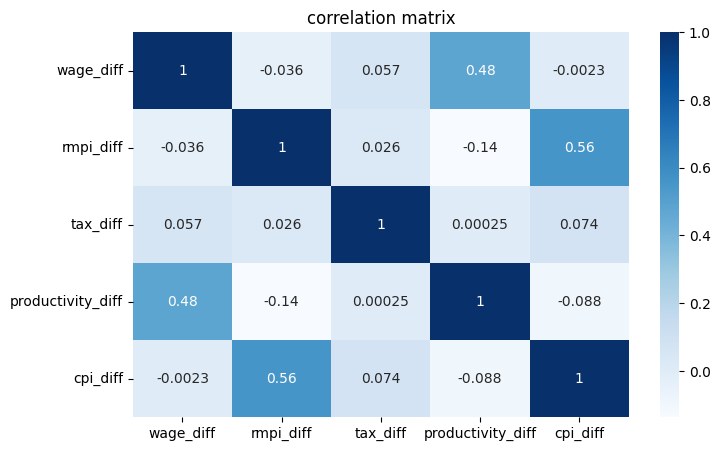

In [59]:
cor_matrix = data[trf_vars].corr()

plt.figure(figsize = (8, 5))
sns.heatmap(cor_matrix,
            annot = True,
            cmap = 'Blues')
plt.title('correlation matrix')
plt.show()

The matrix above shows a moderate collinearity between wages and productivity. This can be problematic for modelling, as we are feeding redundant data into our model. This issue can be addressed using principal component analysis.

### PCA Analysis



In [97]:
trf_features = ['wage_diff', 'productivity_diff', 'tax_diff', 'rmpi_diff']


In [98]:
pca = PCA(n_components = 3)
XPC = pca.fit_transform(data[trf_features])

pca_cols = [f'PC{i+1}' for i in range(pca.n_components)]

print('explained variance ratio:', pca.explained_variance_ratio_)
print('singular values:', pca.singular_values_)
print('shape of xpc:', XPC.shape)

explained variance ratio: [0.36643516 0.35114111 0.26718741]
singular values: [0.64685014 0.63320736 0.55234841]
shape of xpc: (287, 3)


I performed the PCA on the scaled and transformed data so that the results would reflect the relationships between the features, rather than the trends or seasonality. PC1 - PC4 creates a new set of variables which themselves are combinations of the original variables. PC1 captures 36.6% of the overall variance, PC2 captures 35.1%, and so on.

pairplot showing correlation between priciple componets




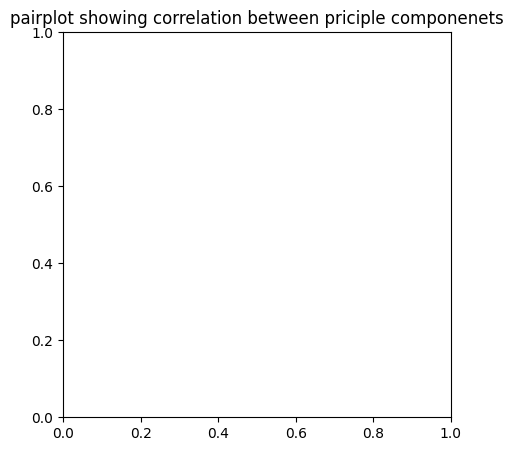

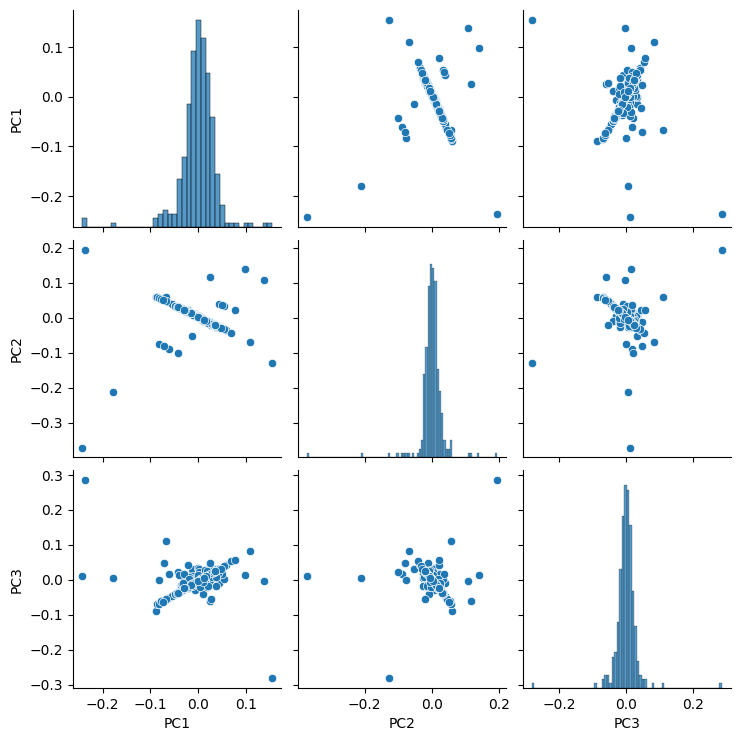

In [99]:
plt.figure(figsize = (5, 5))

plt.title('pairplot showing correlation between priciple componenets')
df = pd.DataFrame(XPC, columns=['PC1', 'PC2', 'PC3'])
df['Date'] = data['Date']
sns.pairplot(df)

print('pairplot showing correlation between priciple componets\n\n')
plt.show()

### Clustering

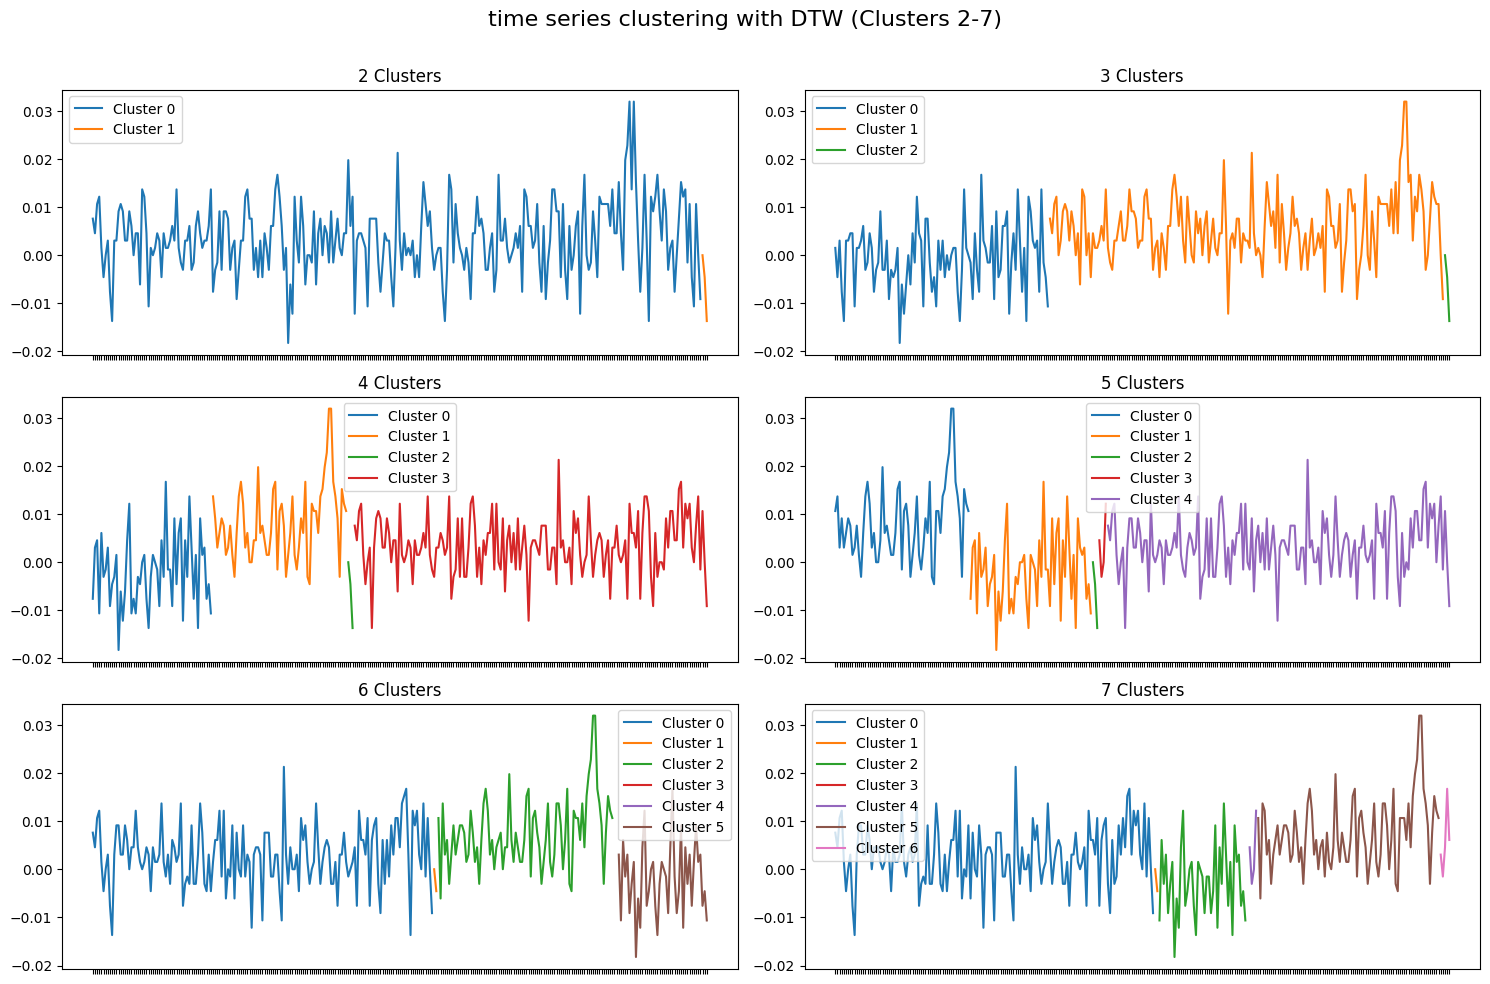

In [100]:
# clustreing
X_pc = XPC

fig, axes = plt.subplots(3,
                         2,
                         figsize = (15, 10))
fig.suptitle('time series clustering with DTW (Clusters 2-7)',
             fontsize = 16)

for i, n_clusters in enumerate(range(2, 8)):
    row = i // 2
    col = i % 2

    # k-means, dtw metric
    kmeans = TimeSeriesKMeans(n_clusters = n_clusters,
                              metric = 'dtw',
                              max_iter = 10)
    kmeans.fit(X_pc)
    labels = kmeans.labels_

     # plot
    ax = axes[row, col]
    for cluster in range(n_clusters):
        cluster_indices = np.where(labels == cluster)[0]

        ax.plot(data['Date'].iloc[cluster_indices],
                data['cpi_diff'].iloc[cluster_indices],
                label = f'Cluster {cluster}')

    ax.set_xticklabels([])
    ax.set_title(f'{n_clusters} Clusters')
    ax.legend()

plt.tight_layout()
plt.subplots_adjust(top = 0.9)
plt.show()

To further explore the data, I did some clustering. The plots above show the differenced CPI time series in various clusters based upon the principal components. I could probably base an entire project upon PC analysis (anomaly detection, maybe an early warning system for impending economic doom?), but I will avoid falling down this rabbit hole at this tim and move on with my agenda.

## Modeling

### ARIMA

In [87]:
# split data
train_data = data[(data['Date'] >= '2009-07-01') & (data['Date'] <= '2015-06-30')]
test_data = data[(data['Date'] >= '2015-07-01') & (data['Date'] <= '2018-06-30')]

In [93]:
train_data[pca_cols] = XPC[:len(train_data)]
test_data[pca_cols] = XPC[len(train_data):len(train_data) + len(test_data)]

<ipython-input-93-85dd95dba0a8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[pca_cols] = XPC[:len(train_data)]
<ipython-input-93-85dd95dba0a8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[pca_cols] = XPC[len(train_data):len(train_data) + len(test_data)]
<ipython-input-93-85dd95dba0a8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [ ]:
features = []
target = []

In [94]:
X_train_pca = train_data[pca_cols]
y_train = train_data[target]
X_test_pca = test_data[pca_cols]
y_test = test_data[target]

In [ ]:


# Fit the ARIMA model
# You need to determine the best (p,d,q) order for your model.
# Use the ACF and PACF plots and potentially try different orders
# to find what minimizes AIC, BIC and gives the best out-of-sample forecasts

#Example Order (p,d,q) = (5,1,0)
model = ARIMA(train_data['cpi_diff'], order=(5, 1, 0))
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=len(train_data), end=len(data)-1)


# Evaluate the model
rmse = np.sqrt(mean_squared_error(test_data['cpi_diff'], predictions))
print(f'RMSE for ARIMA model for cpi: {rmse}')

# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(test_data['Date'], test_data['cpi_diff'], label='Actual')
plt.plot(test_data['Date'], predictions, label='Predictions')
plt.legend()
plt.title('ARIMA Predictions vs. Actual CPI Differences')
plt.show()


# Repeat the above steps for other variables (wage_diff, rmpi_diff, etc.)
# You might need to experiment with different (p,d,q) orders for each variable.
# Example for wage_diff:
model_wage = ARIMA(train_data['wage_diff'], order=(5,1,0))
model_wage_fit = model_wage.fit()

predictions_wage = model_wage_fit.predict(start=len(train_data), end=len(data)-1)
rmse_wage = np.sqrt(mean_squared_error(test_data['wage_diff'], predictions_wage))

print(f'RMSE for ARIMA model for wage: {rmse_wage}')


#Plot for wage
plt.figure(figsize=(10, 6))
plt.plot(test_data['Date'], test_data['wage_diff'], label='Actual')
plt.plot(test_data['Date'], predictions_wage, label='Predictions')
plt.legend()
plt.title('ARIMA Predictions vs. Actual Wage Differences')
plt.show()


## References

1. [Statistics Canada SDMX userguide](https://www.statcan.gc.ca/en/developers/sdmx/user-guide)
2. [OpenAI](https://chatgpt.com/)
3. [sklearn documentation](https://scikit-learn.org/1.6/)
4. [Towards Data Science: PCA Analysis](https://towardsdatascience.com/the-pca-trick-with-time-series-d40d48c69d28)